In [1]:
import hydra
import torch
import matplotlib.pyplot as plt
import numpy as np


from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize


import sys

sys.path.append("../")

from complex_neural_source_localization.dataset import DCASE2019Task3Dataset, load_multichannel_wav, create_dataloaders
from complex_neural_source_localization.model import DOACNet
from complex_neural_source_localization.utils.model_visualization import (
    plot_multichannel_spectrogram,
    plot_spectrogram,
    plot_model_output,
    plot_real_feature_maps,
    plot_real_feature_map
)
from complex_neural_source_localization.trainer import DOACNetLightniningModule

def plot_mag_phase(features, unwrap=True):
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    axs[0].plot(features.abs())
    if unwrap:
        axs[1].plot(np.unwrap(features.angle().numpy()))
    else:
        axs[1].plot(features.angle().numpy())
    plt.show()

def scatter_complex(complex_vector):
    fig, ax = plt.subplots()
    ax.scatter(complex_vector.real, complex_vector.imag)

GlobalHydra.instance().clear()
initialize(config_path="../config")
config = compose("config")

MODEL_CHECKPOINT_PATH = "/Users/ezajlerg/datasets/complex_valued_source_localization/weights_fully_complex.ckpt"

In [2]:
dataset = create_dataloaders(config)[0] # 0=train | -1=test
dataset = iter(dataset)

model = DOACNetLightniningModule(config)
model.model.track_feature_maps()
model.eval()
checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"], strict=False)


<All keys matched successfully>

In [39]:
batch = next(dataset)
model_output = model(batch[0])
predicted_azimuths = torch.atan2(model_output[:, 1], model_output[:, 0])
feature_maps = model.model.feature_maps

print("Ground truth azimuths:", batch[1]['azimuth_in_radians'])
print("Predicted azimuth:", predicted_azimuths)


Ground truth azimuths: tensor([[1.2217],
        [2.2689]])
Predicted azimuth: tensor([1.3700, 2.2991], grad_fn=<Atan2Backward0>)


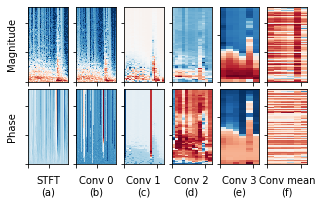

In [47]:
NUM_CONV_LAYERS = 4

number_to_letter = {
    0: "a",
    1: "b",
    2: "c",
    3: "d",
    4: "e",
    5: "f"
}

def plot_feature_maps(feature_maps, batch_idx, figsize=(5, 3)):
    fig, axs = plt.subplots(nrows=2, ncols=NUM_CONV_LAYERS + 2, figsize=figsize)
    
    (mag_mesh, phase_mesh) = plot_spectrogram(feature_maps["stft"][batch_idx][0], axs=axs[:, 0], colorbar=False)[0]
    axs[1, 0].set_xlabel(f"STFT\n({number_to_letter[0]})")
    
    for i in range(NUM_CONV_LAYERS):
        plot_spectrogram(feature_maps[f"conv_{i}"][batch_idx][0].transpose(-1, -2), axs=axs[:, i + 1], colorbar=False)
        axs[1, i + 1].set_xlabel(f"Conv {i}\n({number_to_letter[i + 1]})")
    
    mean_conv = torch.mean(feature_maps["conv_3"][batch_idx], dim=-1)
    plot_spectrogram(mean_conv, close=False, unwrap=False, axs=axs[:, -1], colorbar=False)
    axs[1, -1].set_xlabel(f"Conv mean\n({number_to_letter[5]})")
    
    axs[0, 0].set_ylabel("Magnitude")
    axs[1, 0].set_ylabel("Phase")
    
#     plt.colorbar(mag_mesh, ax=axs[:, 0], format="%+2.f dB", location = "bottom")
#     plt.colorbar(phase_mesh, ax=axs[:, 1], format="%+4.f rad", location="bottom")
    
    return axs

plot_feature_maps(feature_maps, 1)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1, bottom=0.15)
#plt.tight_layout()

plt.savefig("features.pdf", bbox_inches='tight')

Ground truth azimuth: tensor([1.5708])
Predicted azimuth: tensor(1.9380, grad_fn=<SelectBackward0>)


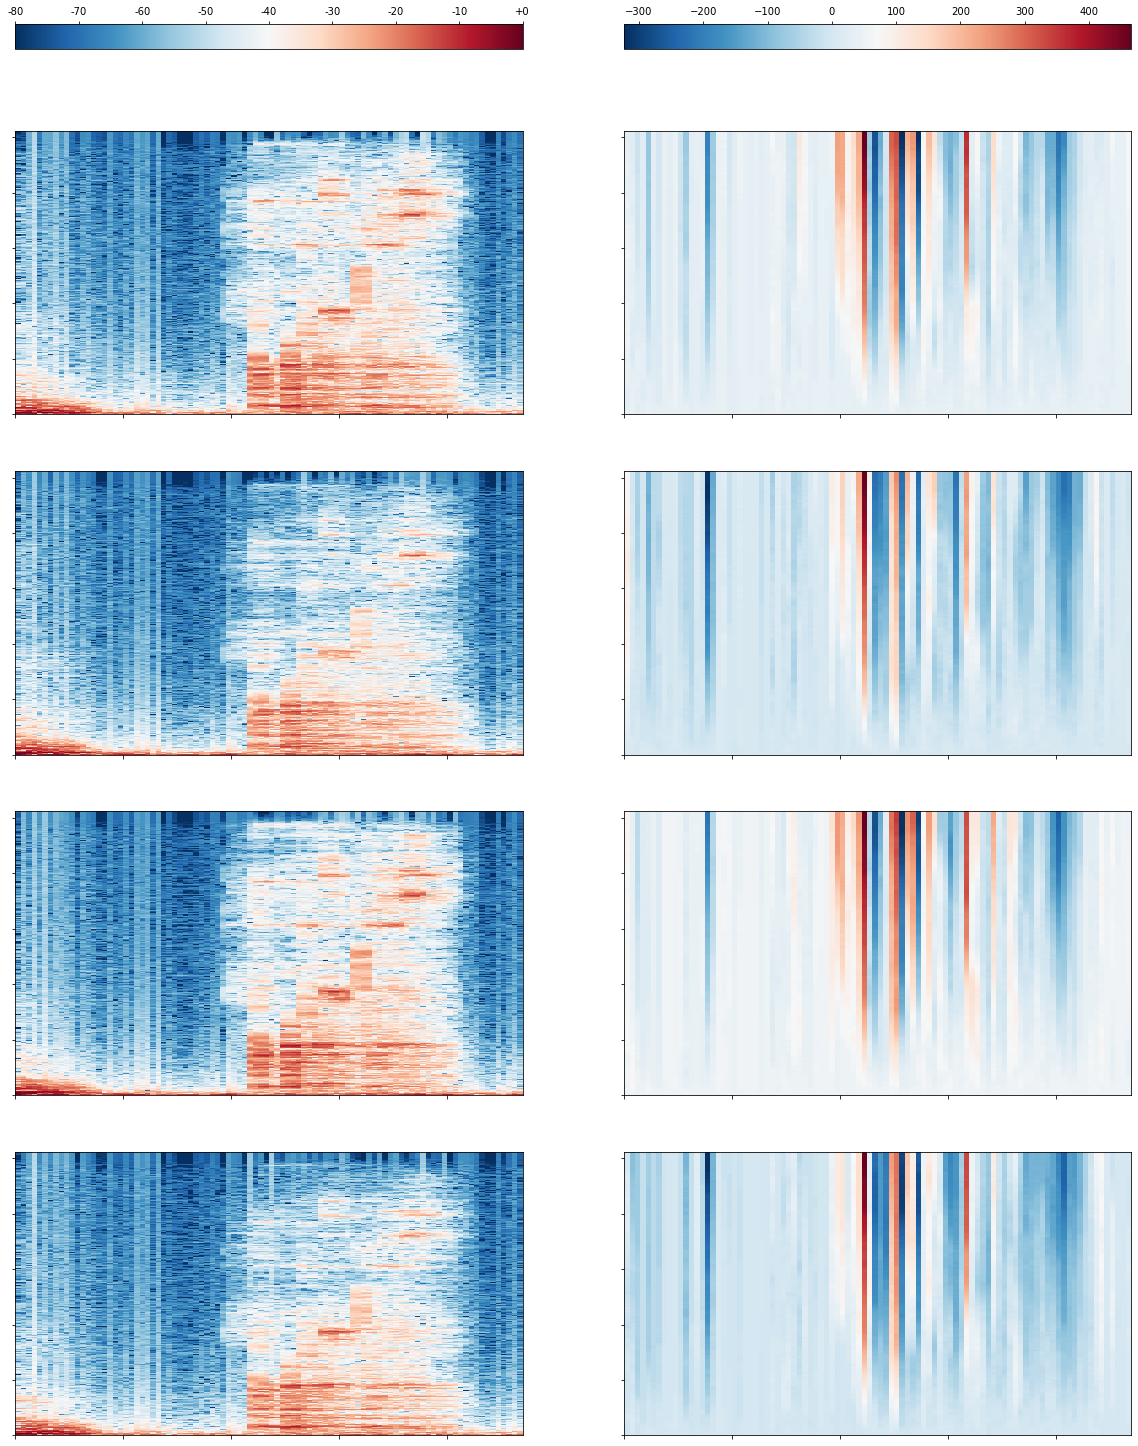

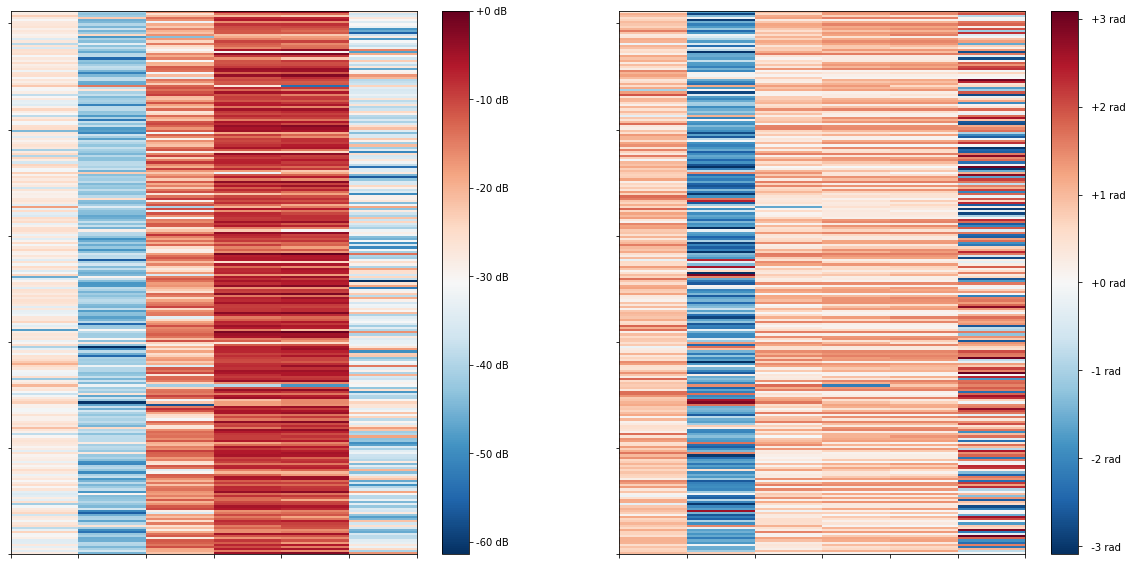

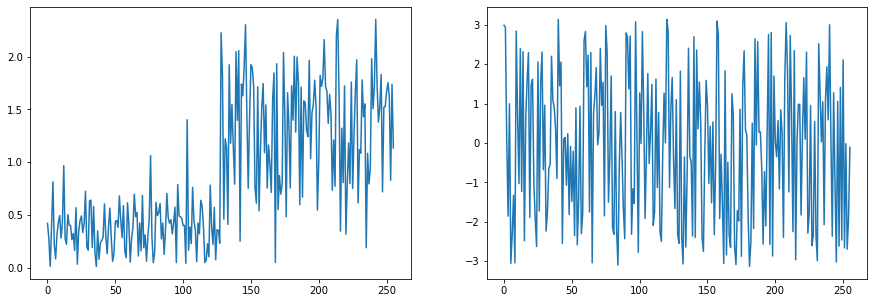

In [10]:
batch_idx = 1
print("Ground truth azimuth:", batch[1]['azimuth_in_radians'][batch_idx])
print("Predicted azimuth:", predicted_azimuths[batch_idx])

# 1. Plot input features
plot_multichannel_spectrogram(feature_maps["stft"][batch_idx], mode="row", figsize=(20, 30), close=False, unwrap=True)

# # 2. Plot convolutional layers
# plot_multichannel_spectrogram(feature_maps["conv_0"][batch_idx].transpose(-1, -2), close=False, mode="row",
#                 figsize=(10, 40), unwrap=True)
# plot_multichannel_spectrogram(feature_maps["conv_1"][batch_idx].transpose(-1, -2), close=False, mode="row",
#                 figsize=(10, 60), unwrap=True)
# plot_multichannel_spectrogram(feature_maps["conv_2"][batch_idx].transpose(-1, -2), close=False, mode="row",
#                 figsize=(10, 120), unwrap=True)
# plot_multichannel_spectrogram(feature_maps["conv_3"][batch_idx].transpose(-1, -2), close=False, mode="row",
#                 figsize=(10, 240), unwrap=True)

mean_conv = torch.mean(feature_maps["conv_3"][batch_idx], dim=-1)
plot_spectrogram(mean_conv, close=False, mode="row",
                figsize=(20, 10), unwrap=False, unwrap_mode="time")

# 3. Plot recurrent layer
# plot_spectrogram(feature_maps["rnn"][batch_idx].T, close=False, mode="row",
#                 figsize=(20, 10), unwrap=False, unwrap_mode="time")


mean_rnn = torch.mean(feature_maps["rnn"][batch_idx], dim=0)
plot_mag_phase(mean_rnn, unwrap=False)

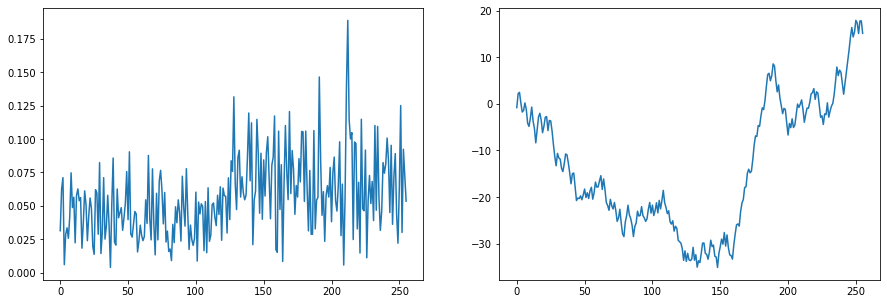

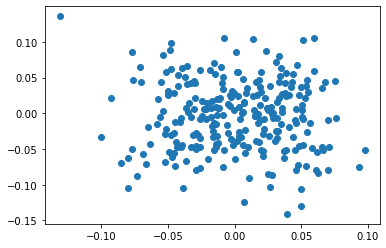

In [6]:
def get_params(model, prefix=""):
    params = {
        name: value for name, value in model.named_parameters()
        if name.startswith(prefix)
    }

    return params


params = get_params(model, "model.azimuth_fc")
linear_weights = torch.complex(params["model.azimuth_fc.fc_r.weight"],
                               params["model.azimuth_fc.fc_i.weight"])[0].detach()
bias_weights = torch.complex(params["model.azimuth_fc.fc_r.bias"],
                               params["model.azimuth_fc.fc_i.bias"]).detach()

plot_mag_phase(linear_weights[:linear_weights.shape[0]], unwrap=True)
scatter_complex(linear_weights[:linear_weights.shape[0]])

## Training visualization

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import MaxNLocator

RESULTS_PATH = "/Users/ezajlerg/train_results.csv"

results_df = pd.read_csv(RESULTS_PATH)

print(results_df)


def plot_loss(results_df, loss_complex, loss_real):
    fig, axs = plt.subplots(nrows=3, sharex=False, sharey=False)
    
    train_df = results_df[["Train real", "Train complex"]]
    validation_df = results_df[["Validation real", "Validation complex"]]
    
    labels = ["Real-valued network", "Complex-valued network"]
    
    axs[0].plot(train_df, label=labels)
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xlabel("Epoch number")
    axs[0].set_ylabel("Train err. (°)")
    axs[0].legend()
    
    axs[1].plot(validation_df, label=labels)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xlabel("Epoch number")
    axs[1].set_ylabel("Valid. err. (°)")
    axs[1].legend()
    
    axs[2].hist([loss_complex, loss_real], bins=20, label=labels, range=(0, 6))
    #axs[2].set_yticks([])
    axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    axs[2].set_xlabel("Test err. (°)")
    axs[2].set_ylabel("Num. samples")
    axs[2].legend()
    
    return axs


axs = plot_loss(results_df)
plt.savefig("training_error.eps")

    Train complex  Train real  Validation complex  Validation real
0        0.317481    0.556909            0.198167         0.219385
1        0.144858    0.201919            0.084705         0.304596
2        0.108272    0.138164            0.090121         0.097571
3        0.092522    0.108025            0.104723         0.111889
4        0.084080    0.095952            0.072040         0.369222
5        0.068752    0.078253            0.078461         0.142675
6        0.065079    0.072350            0.063454         0.064626
7        0.064332    0.072307            0.059468         0.062911
8        0.056322    0.069147            0.050035         0.079646
9        0.061410    0.066042            0.055653         0.102739
10       0.048754    0.061525            0.046676         0.053807
11       0.049161    0.055060            0.049199         0.050813
12       0.046673    0.056819            0.047088         0.076668
13       0.043848    0.054713            0.047686         0.05

TypeError: plot_loss() missing 2 required positional arguments: 'loss_complex' and 'loss_real'

## Test error visualization

In [ ]:
import pickle
import torch

real_results_path = "../tests/fixtures/test_real.pickle"
complex_results_path = "../tests/fixtures/test_complex.pickle"

torch.load(real_results_path,map_location=torch.device('cpu'))
# with open(real_results_path, "rb") as f:
#     real_results = pickle.load(f)
    